# Following 1812.05326

In [1]:
import numpy
import py_monte_carlo
from matplotlib import pyplot

In [2]:
side_len = 6
nvars = side_len*side_len

x = numpy.arange(side_len)
y = x
X, Y = numpy.meshgrid(x, y)

INDX = Y*side_len + X
RIGHT = Y*side_len + (X+1)%side_len
BOT = (((Y+1) % side_len )*side_len + X)

right_edges = [((a, b), -1.0) for a, b in zip(INDX.flatten(), RIGHT.flatten())]
bot_edges = [((a, b), -1.0 if b%2 else 1.0) for a, b in zip(INDX.flatten(), BOT.flatten())]

edges =  right_edges + bot_edges

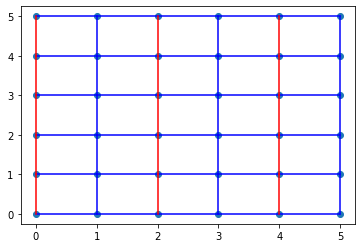

In [3]:
pyplot.scatter(X.flatten(), Y.flatten())
for (a,b),j in edges:
    c = 'b'
    if j > 0:
        c = 'r'
    ax = a % side_len
    ay = a // side_len
    bx = b % side_len
    by = b // side_len
    if abs(bx - ax) <= 1 and abs(by - ay) <= 1: 
        pyplot.plot([ax, bx], [ay, by], c)
    else:
        pass
        #pyplot.plot(xs, ys, c+'--')

In [4]:
transverse = 0.2
beta = 10.0

In [5]:
graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)

In [6]:
bond_correlation = numpy.mean(numpy.asarray(graph.run_quantum_monte_carlo_and_measure_bond_autocorrelation(beta, 20000, 16, sampling_wait_buffer=10000)), axis=0)

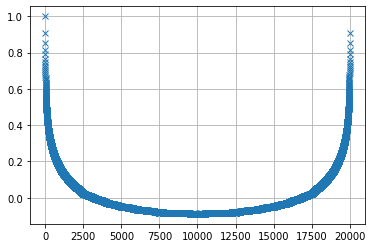

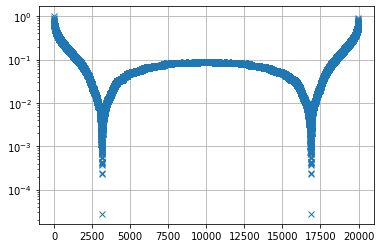

In [7]:
pyplot.plot(bond_correlation, 'x')
pyplot.grid()
pyplot.show()
pyplot.plot(abs(bond_correlation), 'x')
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

In [8]:
var_correlation = numpy.mean(numpy.asarray(graph.run_quantum_monte_carlo_and_measure_variable_autocorrelation(beta, 20000, 16, sampling_wait_buffer=10000)), axis=0)

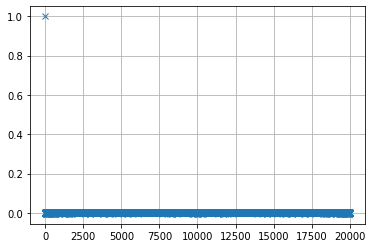

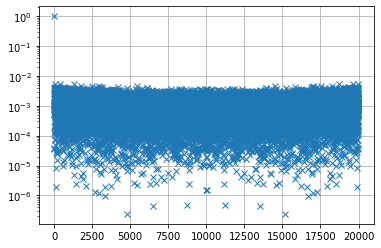

In [9]:
pyplot.plot(var_correlation, 'x')
pyplot.grid()
pyplot.show()
pyplot.plot(abs(var_correlation), 'x')
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

We can check for columnar states using P((a,b) ^ (//a,b))

In [10]:
graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)
states, energy = graph.run_quantum_monte_carlo_sampling(beta, 10000, 1)[0]

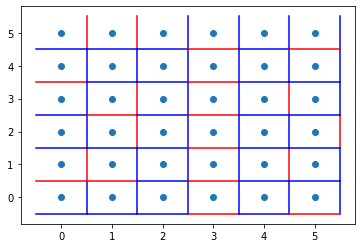

(20, 8)


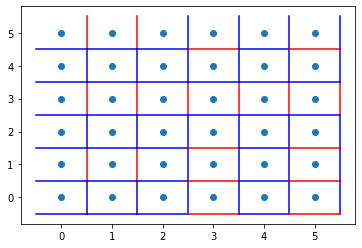

(18, 14)


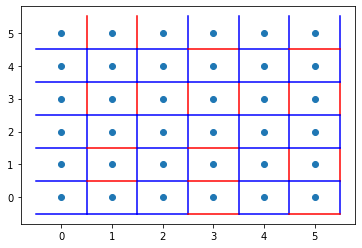

(18, 13)


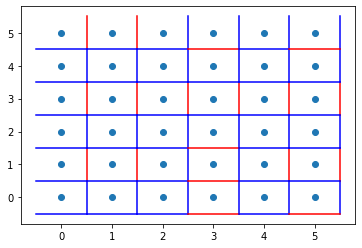

(18, 14)


In [11]:
def parallel(a, b):
    ax, ay = a
    bx, by = b
    dx = bx - ax
    dy = by - ay
    ny = (by + dy) % side_len
    nx = (bx + dx) % side_len
    return (bx, by), (nx, ny)

def plot_state(state):
    edge_gen = ((state[a] ^ state[b],j) for (a,b), j in edges)
    dimer_states = [a if j<0 else not a for a,j in edge_gen]
    all_indices = numpy.asarray([(a,b) for (a,b),_ in edges])
    x_all_indices = all_indices % side_len
    y_all_indices = all_indices // side_len
    all_coords = numpy.dstack([x_all_indices, y_all_indices])
    dimer_lookup = dict(((tuple(a), tuple(b)), s) for (a,b), s in zip(all_coords, dimer_states))
    
    pyplot.scatter(X.flatten(), Y.flatten())
    for k,v in dimer_lookup.items():
        c = 'b'
        if v:
            c = 'r'
        a, b = k
        xs, ys = zip(a, b)
        
        xs = list(xs)
        ys = list(ys)
        if abs(xs[0] - xs[1]) > 1:
            xs[0] = max(xs[0], xs[1])
            xs[1] = xs[0] + 1
        if abs(ys[0] - ys[1]) > 1: 
            ys[0] = min(ys[0], ys[1]) - 1
            ys[1] = ys[0] + 1
        
        avg_x = sum(xs)/2.0
        avg_y = sum(ys)/2.0

        if xs[0] == xs[1]:
            pyplot.plot([avg_x-0.5, avg_x+0.5], [avg_y,avg_y], c)
        else:
            pyplot.plot([avg_x, avg_x], [avg_y-0.5,avg_y+0.5], c)
        
    pyplot.show()
    
    tot = 0
    count = 0
    for k in filter(lambda k: dimer_lookup[k], dimer_lookup):
        tot += 1
        if dimer_lookup[parallel(*k)]:
            count += 1
    return (tot, count)
    
print(plot_state(states[-5000]))
print(plot_state(states[-500]))
print(plot_state(states[-50]))
print(plot_state(states[-1]))

In [12]:
state_mat = numpy.asarray(states)*2 - 1
state_corr = state_mat @ state_mat.T
state_corr

array([[ 36,   2,  -4, ...,   4,  -4,   4],
       [  2,  36,  14, ...,  -2,   2,  -2],
       [ -4,  14,  36, ..., -16,  16, -16],
       ...,
       [  4,  -2, -16, ...,  36, -36,  36],
       [ -4,   2,  16, ..., -36,  36, -36],
       [  4,  -2, -16, ...,  36, -36,  36]])

In [13]:
dimer_mat = numpy.zeros((len(states), len(edges)))

for i, state in enumerate(states):
    edge_gen = ((state[a] ^ state[b],j) for (a,b), j in edges)
    dimer_states = [a if j<0 else not a for a,j in edge_gen]
    dimer_mat[i,:] = dimer_states
dimer_mat = dimer_mat * 2 - 1
dimer_corr = dimer_mat @ dimer_mat.T / dimer_mat.shape[1]

mean_norm_dimer = dimer_mat - numpy.mean(dimer_mat, axis=0)
norms = numpy.sqrt(numpy.sum(mean_norm_dimer**2, axis=-1))
norms = numpy.expand_dims(norms, -1)
mean_norm_dimer = mean_norm_dimer / norms
mean_norm_dimer_corr = mean_norm_dimer @ mean_norm_dimer.T

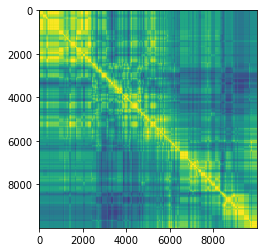

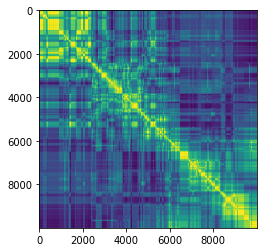

In [14]:
pyplot.imshow(dimer_corr)
pyplot.show()

pyplot.imshow(mean_norm_dimer_corr)
pyplot.show()

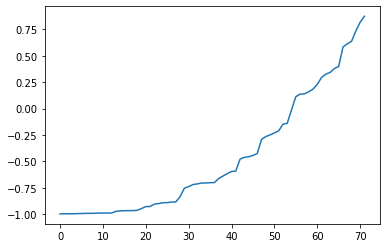

In [15]:
pyplot.plot(sorted(numpy.mean(dimer_mat, axis=0)))
pyplot.show()

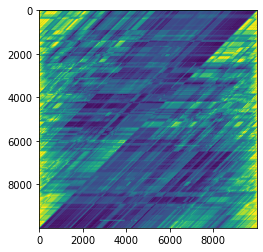

In [16]:
new_mean_norm_dimer_corr = mean_norm_dimer_corr.copy()
for t in range(1, mean_norm_dimer_corr.shape[0]):
    new_mean_norm_dimer_corr[t,:] = numpy.roll(new_mean_norm_dimer_corr[t,:], -t)
pyplot.imshow(new_mean_norm_dimer_corr)
pyplot.show()

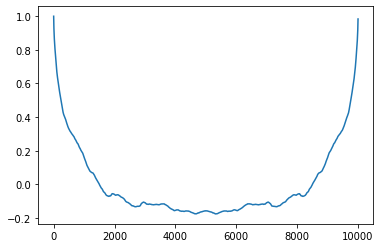

In [17]:
sampling_brute_corr = numpy.mean(new_mean_norm_dimer_corr, axis=0)

pyplot.plot(sampling_brute_corr)
pyplot.show()

In [18]:
import scipy.fft

In [19]:
mean_norm_dimer = dimer_mat - numpy.mean(dimer_mat, axis=0)
mean_norm_dimer = mean_norm_dimer / numpy.expand_dims(numpy.sqrt(numpy.sum(mean_norm_dimer**2, axis=-1)), -1)

In [20]:
dimer_fft = scipy.fft.fft(mean_norm_dimer, axis=0)
sqr_dimer_fft = abs(dimer_fft)**2
reconstructed = numpy.mean(scipy.fft.ifft(sqr_dimer_fft, axis=0), axis=-1)
reconstructed /= reconstructed[0]

/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


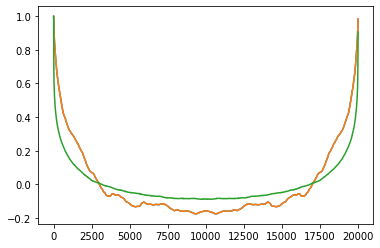

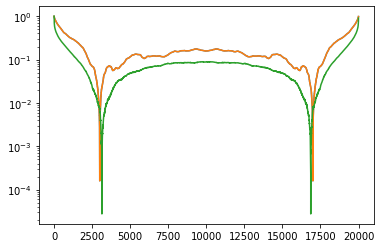

In [21]:
sampling_brute_corr_long = numpy.repeat(sampling_brute_corr, 2)
reconstructed_long = numpy.repeat(reconstructed, 2)

pyplot.plot(sampling_brute_corr_long)
pyplot.plot(reconstructed_long)
pyplot.plot(bond_correlation)
pyplot.show()

pyplot.plot(abs(sampling_brute_corr_long))
pyplot.plot(abs(reconstructed_long))
pyplot.plot(abs(bond_correlation))
pyplot.yscale('log')
pyplot.show()

## Check for Columnar state